In [4]:
import cv2
import glob
import numpy as np

from keras.layers import concatenate
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras.engine.input_layer import Input
import keras
import time

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#matplotlib inline
# y_predict = (y_1,….,y_)
# —> (y_1,…,y_n)/sum(y_i)
# y_true = (z_1,…,z_n)
# —-> (z_1,…,z_n)/sum(z_i)

# KL divergence

Using TensorFlow backend.


In [5]:
def keras_custom_loss_function(y_actual, y_predicted):
    #y_actual = y_actual / np.sum(y_actual) * 128
    #y_predicted = y_predicted / np.sum(y_predicted) * 128
    #print(y_actual)
    custom_loss_value = keras.losses.mean_squared_error(y_actual, y_predicted) # / (128 * 128)
    #custom_loss_value = keras.losses.kullback_leibler_divergence(y_actual, y_predicted)
    return custom_loss_value

In [6]:
def make_image_set(path):
    
    data = []
    files = list(glob.glob(path))
    files.sort()
    
    print("Files")
    
    for myFile in files:
        print(myFile)
        image = cv2.imread(myFile)#.astype('float32')
#         plt.figure()
#         plt.imshow(image)
        image = cv2.resize(image, (128,128))
        #print(image)

        data.append(image[:,:,0])
        
    np_data = np.array(data)

    print()
    
    return np_data

In [7]:
def build_model(input_layer, start_neurons, dropout = 0.05):
    
    #print(input_layer.shape)
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", kernel_initializer = 'he_normal')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    


    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)



    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)



    conv4 = Conv2D(start_neurons * 8, (3, 3), padding="same", kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), padding="same", kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)


    # Middle

    convm = Conv2D(start_neurons * 16, (3, 3), padding="same", kernel_initializer = 'he_normal')(pool4)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), padding="same", kernel_initializer = 'he_normal')(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same", kernel_initializer = 'he_normal')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Activation('relu')(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Activation('relu')(uconv4)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", kernel_initializer = 'he_normal')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv3)
    uconv3 = BatchNormalization()(uconv3)  
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same", kernel_initializer = 'he_normal')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same", kernel_initializer = 'he_normal')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv1)
    uconv1 = BatchNormalization()(uconv1)  
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same", kernel_initializer = 'he_normal')(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    
    
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid", kernel_initializer = 'he_normal')(uconv1)
    output_layer = Conv2D(1, (1, 1))(uconv1)

    return output_layer

# def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
#     """Function to add 2 convolutional layers with the parameters passed to it"""
#     # first layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
#               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     # second layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
#               kernel_initializer = 'he_normal', padding = 'same')(x)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     return x

# def build_model(input_img, n_filters = 16, dropout = 0.05, batchnorm = True):
#     """Function to define the UNET Model"""
#     # Contracting Path
#     c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
#     p1 = MaxPooling2D((2, 2))(c1)
#     p1 = Dropout(dropout)(p1)
    
#     c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
#     p2 = MaxPooling2D((2, 2))(c2)
#     p2 = Dropout(dropout)(p2)
    
#     c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
#     p3 = MaxPooling2D((2, 2))(c3)
#     p3 = Dropout(dropout)(p3)
    
#     c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
#     p4 = MaxPooling2D((2, 2))(c4)
#     p4 = Dropout(dropout)(p4)
    
#     c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
#     # Expansive Path
#     u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
#     u6 = concatenate([u6, c4])
#     u6 = Dropout(dropout)(u6)
#     c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
#     u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
#     u7 = concatenate([u7, c3])
#     u7 = Dropout(dropout)(u7)
#     c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
#     u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
#     u8 = concatenate([u8, c2])
#     u8 = Dropout(dropout)(u8)
#     c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
#     u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
#     u9 = concatenate([u9, c1])
#     u9 = Dropout(dropout)(u9)
#     c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
# #     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
#     outputs = Conv2D(1, (1, 1))(c9)
    
#     return outputs

In [8]:
input_layer = Input(shape=(128, 128, 1))
output_layer = build_model(input_layer, 16)


x_train_path = r"training/images/time_reversal_data/*.png"
x_test_path = r"test/images/time_reversal_data/*.png"
y_train_path = r"training/images/*.tif"
y_test_path = r"test/images/*.tif"

x_train = make_image_set(x_train_path)
x_test = make_image_set(x_test_path)
y_train = make_image_set(y_train_path)
y_test = make_image_set(y_test_path)

x_train = np.reshape(x_train, (28,128,128,1))
x_test = np.reshape(x_test, (12,128,128,1))

y_train = np.reshape(y_train, (28,128,128,1))
y_test = np.reshape(y_test, (12,128,128,1))


def norm(x):
    return (x.astype(np.float32) - 128.0) / 128.0

x_train = norm(x_train)
x_test = norm(x_test)
y_train = norm(y_train)
y_test = norm(y_test)

# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode="wrap",
#     rescale=4)

# imageGen = datagen.flow(x_train, y_train, batch_size=8, shuffle=True)
# #
# datagen.fit(x_train)

x_train_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True)

y_train_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True)

x_train_gen.fit(x_train, seed=1)
y_train_gen.fit(y_train, seed=1)
train_gen = x_train_gen.flow(x_train, batch_size=8, seed=1)
mask_gen = y_train_gen.flow(y_train, batch_size=8, seed=1)

imageGen = zip(train_gen, mask_gen)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Files
training/images/time_reversal_data\recon01.png
training/images/time_reversal_data\recon02.png
training/images/time_reversal_data\recon03.png
training/images/time_reversal_data\recon04.png
training/images/time_reversal_data\recon05.png
training/images/time_reversal_data\recon06.png
training/images/time_reversal_data\recon07.png
training/images/time_reversal_data\recon08.png
training/images/time_reversal_data\recon09.png
training/images/time_reversal_data\recon10.png
training/images/time_reversal_data\recon11.png
training/images/time_reversal_data\recon12.png
training/images/time_reversal_data\recon13.png
training/images/time_reversal_data\recon14.png
training/images/time_reversal_data\recon15.png
training/images/time_reversal_data\recon16.png
training/images/time_reversal_data\recon17.png
training

In [9]:
model = keras.Model(inputs=input_layer, outputs=output_layer)

#optimizer=keras.optimizers.Adadelta(lr=1000.0, rho=0.95)
#sgd = keras.optimizers.SGD(lr=0.5, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
sgd = keras.optimizers.Adam(lr=0.001)

model.compile(loss=keras_custom_loss_function,
          optimizer=sgd)
#           metrics=['accuracy'])

model.summary()



history = model.fit_generator(imageGen, steps_per_epoch=len(x_train), epochs=100, validation_data=(x_test, y_test)) 


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

dict_keys(['val_loss', 'loss'])


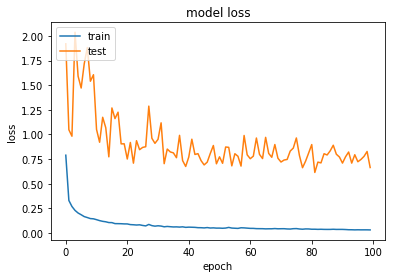

In [10]:
print(history.history.keys())

# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#model.fit(x_train, y_train, batch_size=20, epochs=12, verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


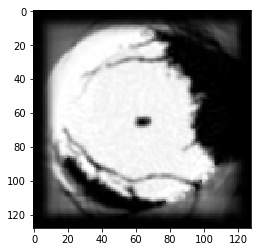

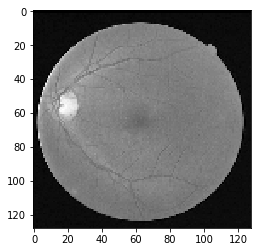

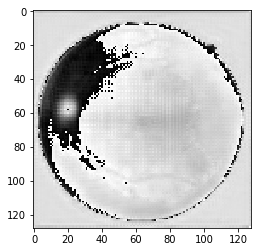

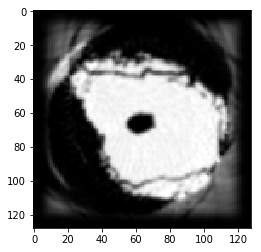

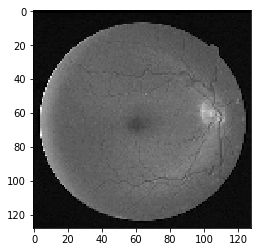

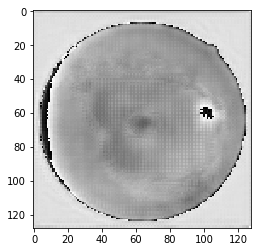

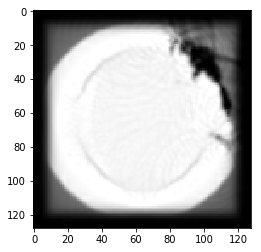

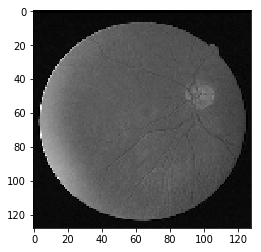

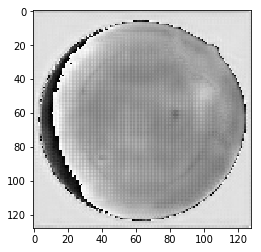

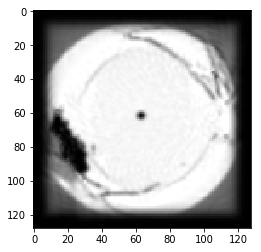

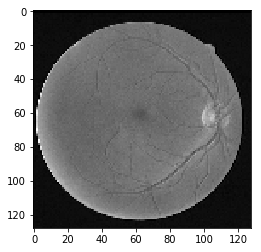

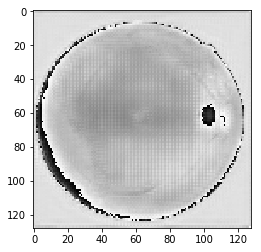

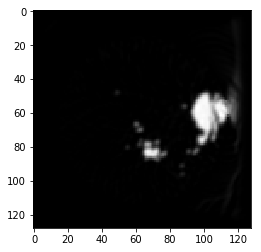

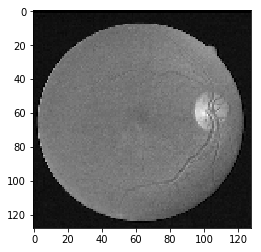

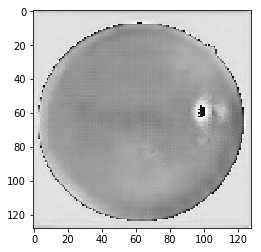

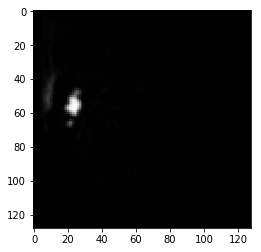

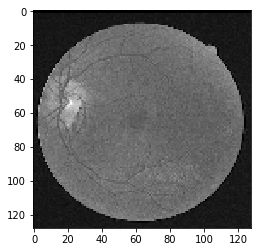

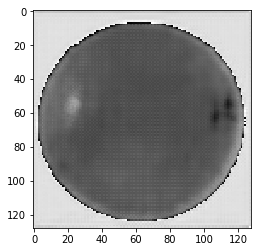

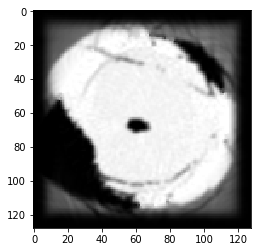

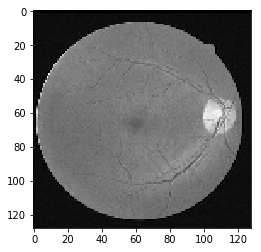

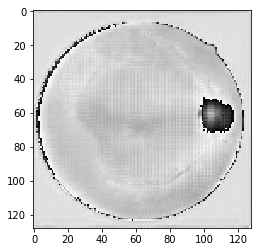

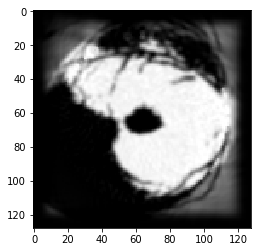

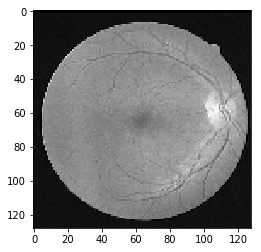

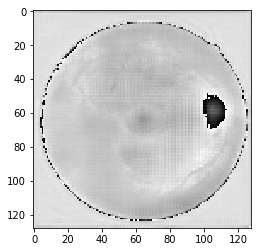

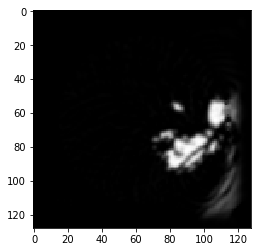

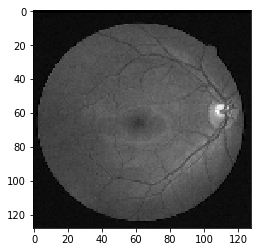

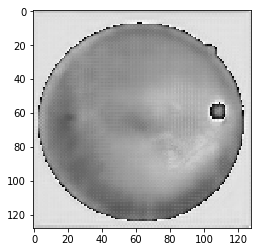

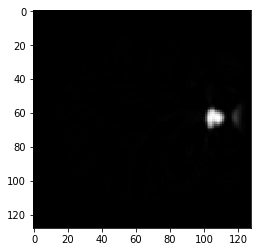

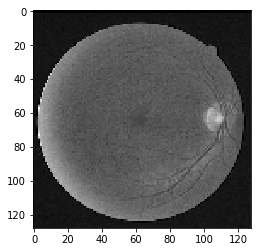

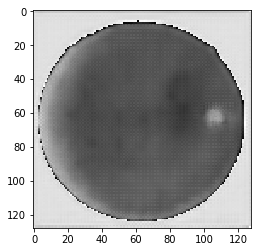

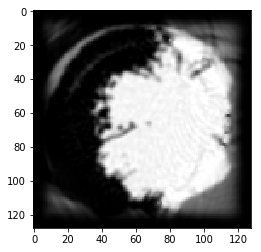

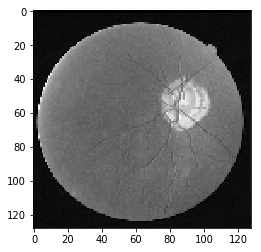

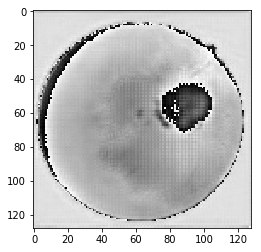

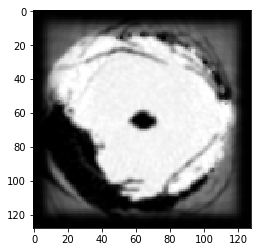

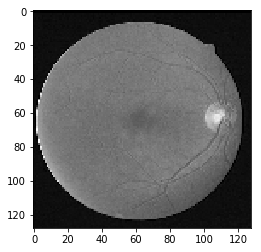

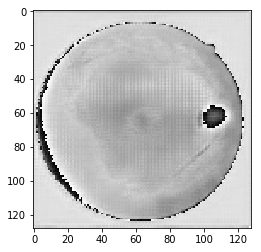

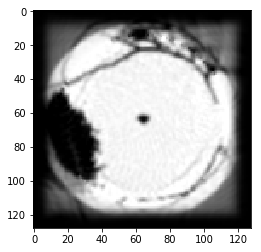

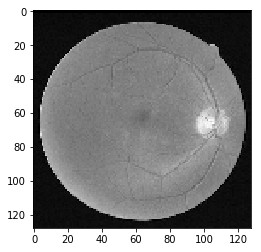

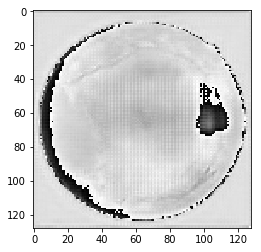

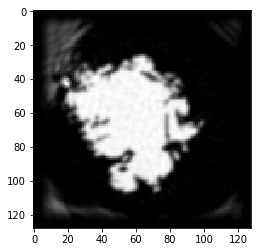

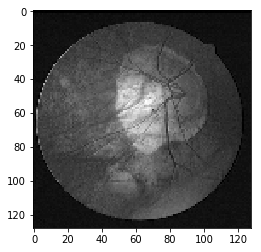

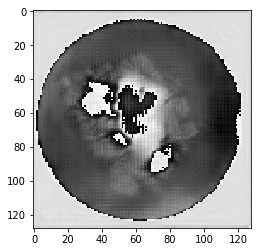

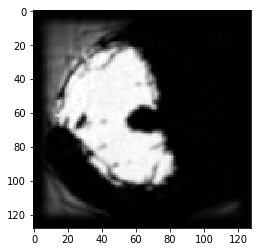

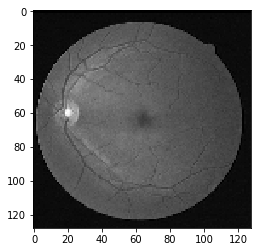

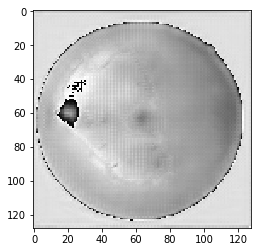

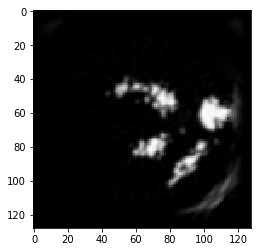

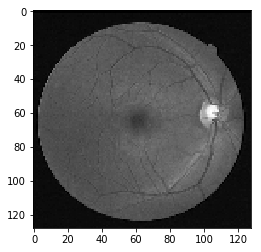

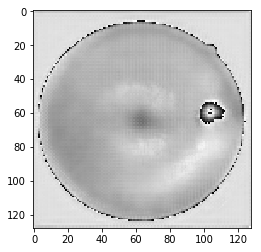

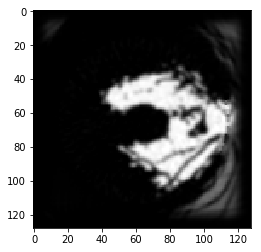

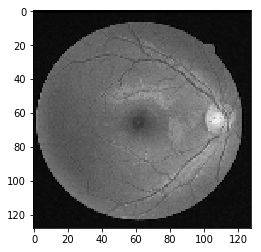

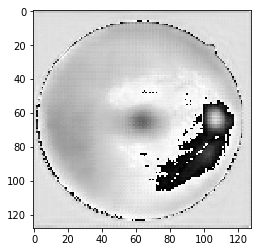

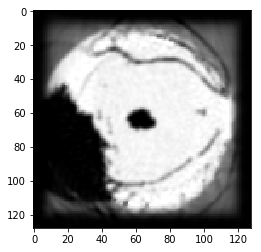

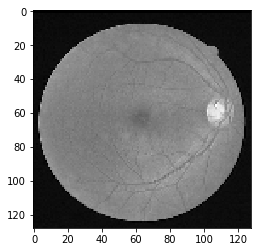

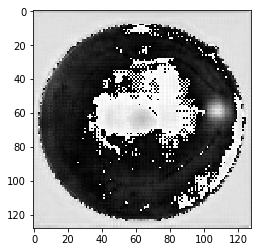

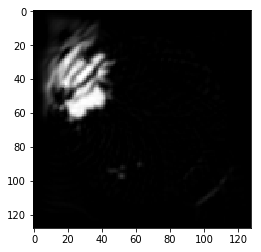

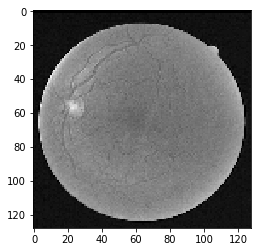

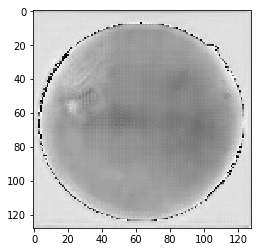

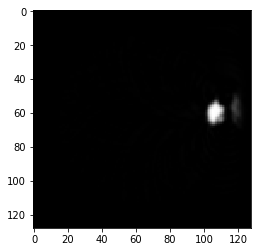

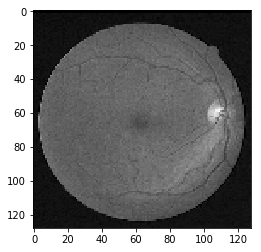

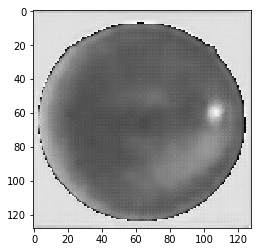

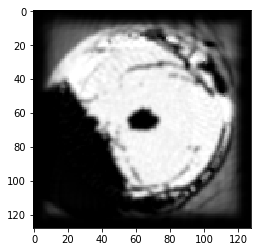

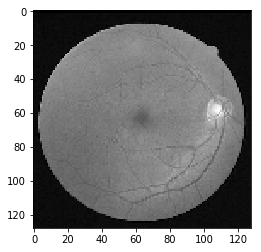

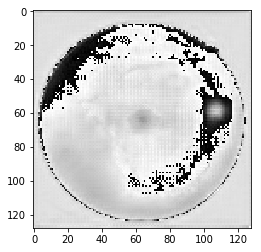

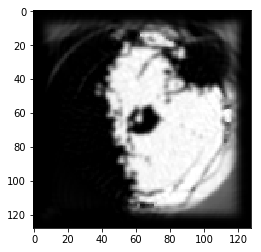

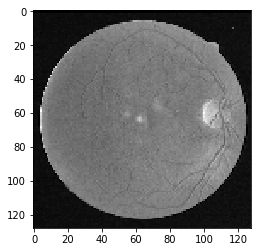

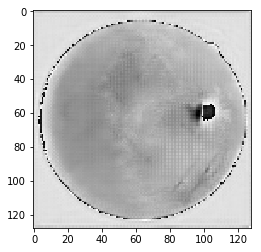

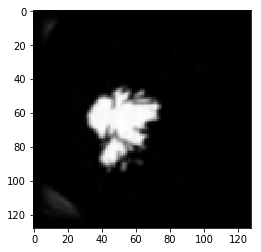

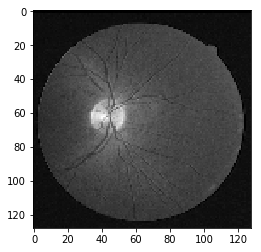

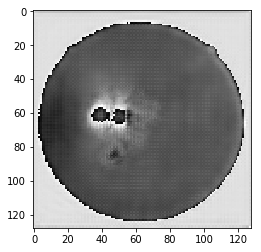

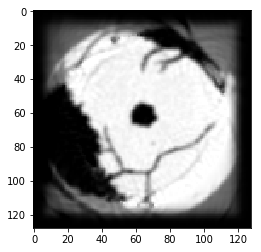

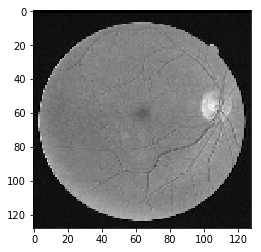

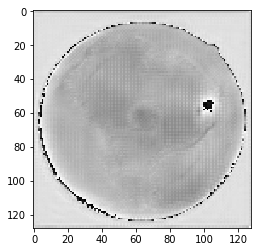

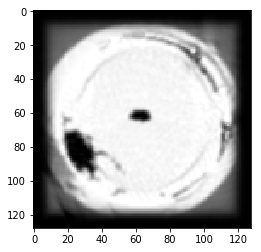

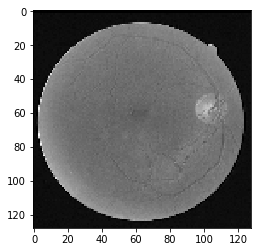

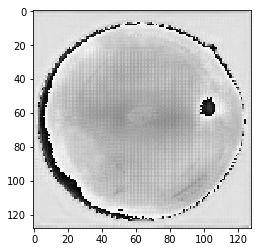

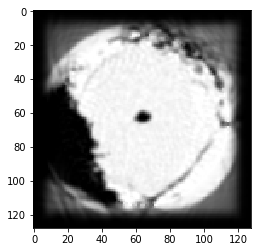

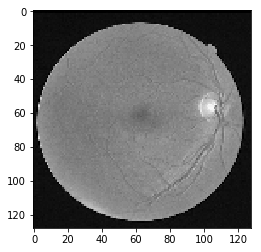

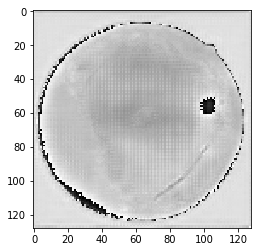

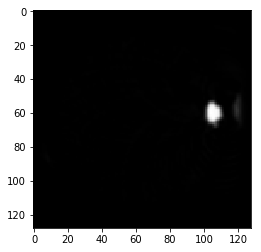

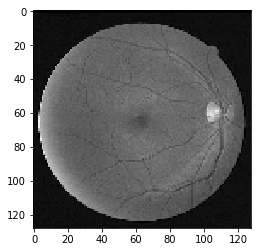

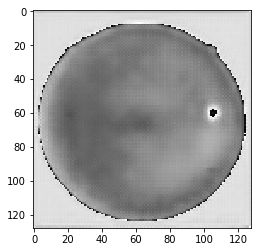

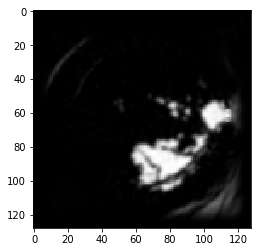

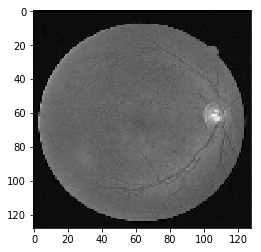

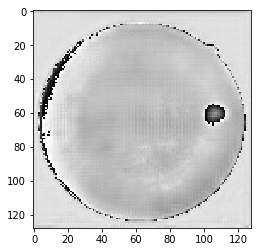

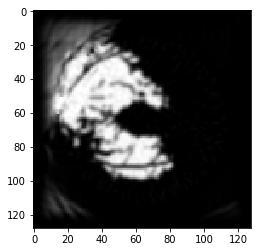

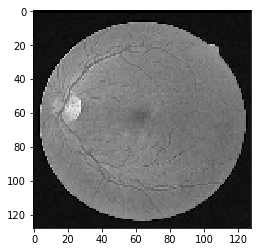

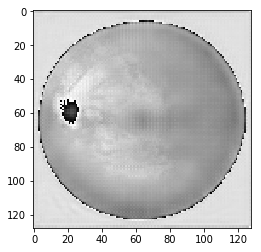

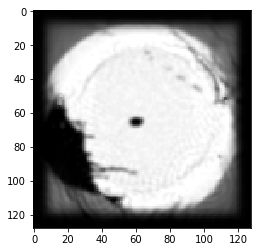

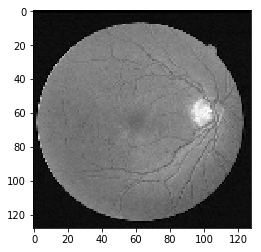

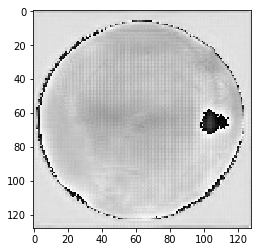

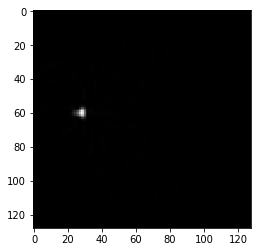

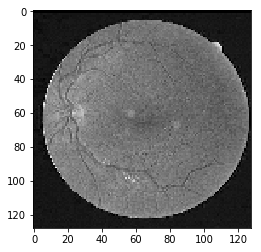

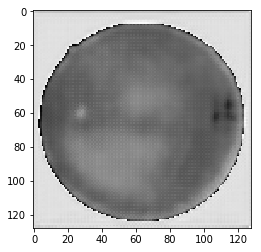

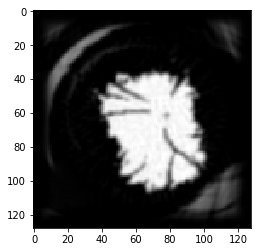

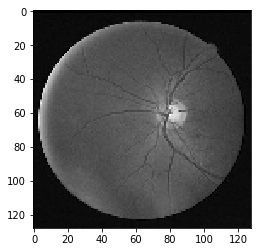

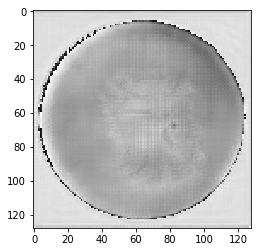

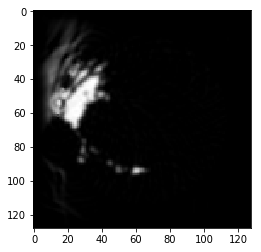

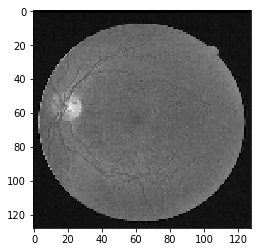

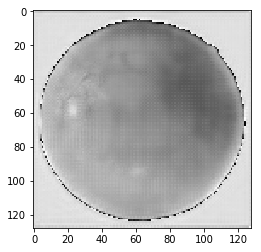

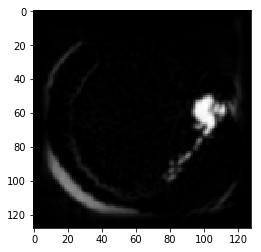

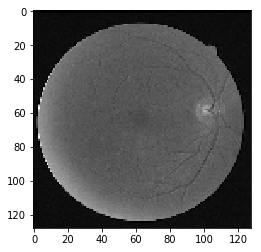

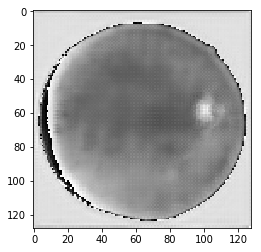

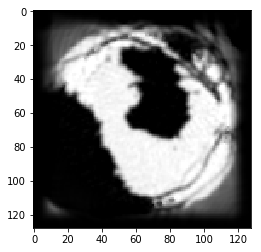

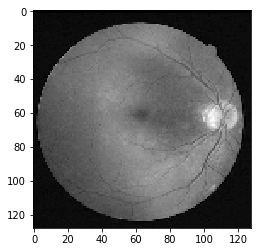

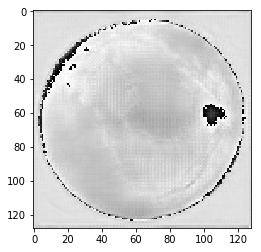

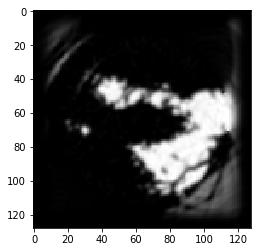

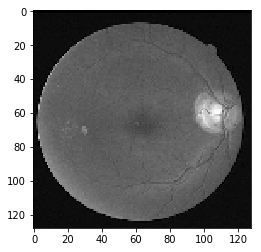

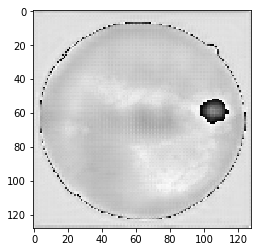

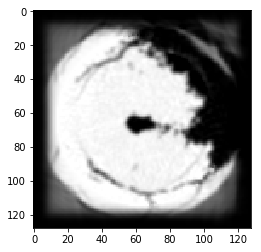

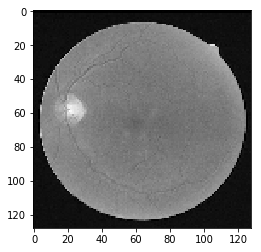

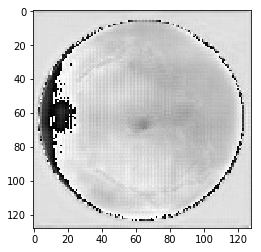

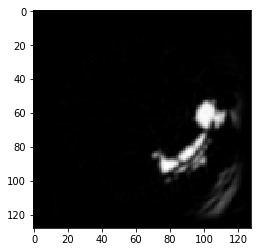

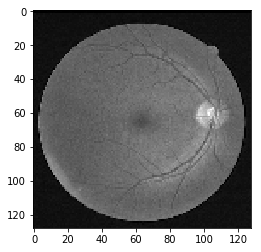

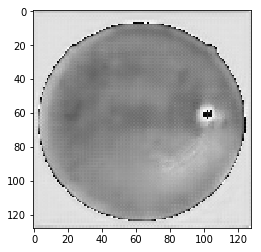

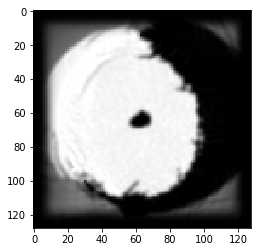

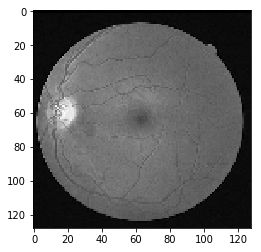

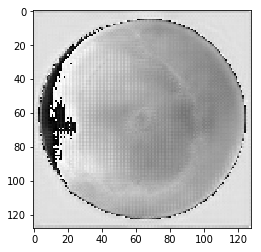

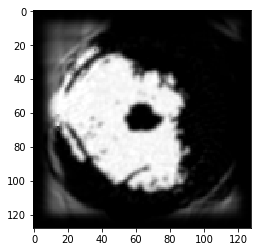

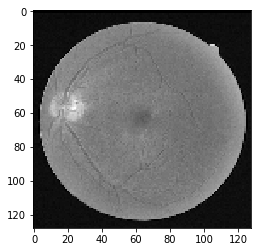

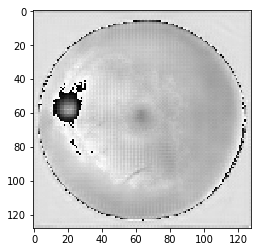

In [11]:
def show(x):
    plt.figure()
    plt.imshow((128*np.squeeze(x) + 128).astype(np.uint8), cmap='gray')

for x, y in zip(x_train, y_train):
    pred = model.predict(x.reshape(1,128,128,1))
    show(x)
    show(y)
    show(pred)

for x, y in zip(x_test, y_test):
    pred = model.predict(x.reshape(1,128,128,1))
    show(x)
    show(y)
    show(pred)